Current quench force calculations for Next Step Fusion design
==========

**Note:** Running this example requires the [triangle](https://pypi.org/project/triangle/) python package, which is installable using `pip` or other standard methods.

In [1]:
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.interpolate import CubicSpline
%matplotlib inline
%config InlineBackend.figure_format = "retina"

### Load TokaMaker library

To load the TokaMaker python module we need to tell python where to the module is located. This can be done either through the `PYTHONPATH` environment variable or using within a script using `sys.path.append()` as below, where we look for the environement variable `OFT_ROOTPATH` to provide the path to where the OpenFUSIONToolkit is installed (`/Applications/OFT` on macOS).

For meshing we will use the \ref OpenFUSIONToolkit.TokaMaker.gs_Domain "gs_Domain()" class to build a 2D triangular grid suitable for Grad-Shafranov equilibria. This class uses the [triangle code](https://www.cs.cmu.edu/~quake/triangle.html) through a [python wrapper](https://pypi.org/project/triangle/).

In [2]:
tokamaker_python_path = os.getenv('OFT_ROOTPATH')
if tokamaker_python_path is not None:
    sys.path.append(os.path.join(tokamaker_python_path,'python'))
sys.path.append('/Applications/OpenFUSIONToolkit/python')
from OpenFUSIONToolkit.TokaMaker import TokaMaker
from OpenFUSIONToolkit.TokaMaker.meshing import load_gs_mesh
from OpenFUSIONToolkit.TokaMaker.util import create_isoflux, read_eqdsk

# Build mesh

## Define vacuum vessel geometry

In [3]:
mesh_pts,mesh_lc,mesh_reg,coil_dict,cond_dict = load_gs_mesh('nextstep_mesh_0801.h5')

## Initialize TokaMaker object
First we create a TokaMaker instance to use for equilibrium calculations. Note at present only a single instance can be used per python kernel, so this command should only be called **once** in a given Jupyter notebook or python script. In the future this restriction may be relaxed

In [4]:
mygs = TokaMaker()
mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
mygs.setup_regions(cond_dict=cond_dict,coil_dict=coil_dict)
mygs.setup(order = 2, F0 =1*3) ## F0 = B0 * R0

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   main
Revision id:          aba6d8f
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = oftpyin                                                                         
XML input file        = none                                                                            
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------


**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  6.143E+00
    # of points  =   10020
    # of edges   =   29927
    # of cells   =   19908
    # of boundary points =     130
    # of boundary edges  =     130
    # of boundary cells  =     130
  Resolution statistics:
    hmin =  3.000E-03
    hrms =  2.845E-02
    hmax =  1.1

# Compute forces on VV due to current quench for an example equilibrium

## Solve for example NT equilibrium

In [5]:
delta = -0.5
fix_xloc = False  #maintains location of x-points when changing triangularity by modifying inner/outer midplane gaps

In [6]:
coil_reg_mat = np.zeros((mygs.ncoils+1,mygs.ncoils+1), dtype=np.float64)
targets = np.zeros(mygs.ncoils+1)
coil_weights = 0.5*np.ones(mygs.ncoils+1)

#Constrain CS current
coil_reg_mat[0,0] = 1
coil_reg_mat[1,1] = 1
coil_reg_mat[1,0] = -1
coil_reg_mat[2,2] = 1
coil_reg_mat[2,1] = -1

targets[0] = -3E6

coil_weights[:3] = 5

#Enforce up/down symmetry in PF coils
coil_reg_mat[3,3] = 1
coil_reg_mat[3,7] = -1
coil_reg_mat[4,4] = 1
coil_reg_mat[4,8] = -1
coil_reg_mat[5,5] = 1
coil_reg_mat[5,9] = -1
coil_reg_mat[6,6] = 1
coil_reg_mat[6,10] = -1

mygs.set_coil_reg(coil_reg_mat, targets, coil_weights)

In [7]:
#Set upper bound on coil currents
coil_bounds = np.zeros((mygs.ncoils+1,2), dtype=np.float64)
coil_bounds[:,0] = -1.E11; coil_bounds[:,1] = 1.E11

#turn off div coils, for now
#coil_bounds[-5:-1, 0] = -122448.979592
#coil_bounds[-5:-1, 1] = 122448.979592
coil_bounds[-3:-1, 0] = 0 
coil_bounds[-3:-1, 1] = 0

mygs.set_coil_bounds(coil_bounds)

In [8]:
# Define shape of P' anf FF' profiles
n_sample = 40
psi_sample = np.linspace(0.0,1.0,n_sample)
# Set F*F' profile
alpha = 2
gamma = 1.25

ffp_prof = {
    'type': 'linterp',
    'x': psi_sample,
    'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
}
ffp_prof['y'] /= ffp_prof['y'][0] # Normalize profile (not required but convienient)
# Set P' profile
alpha = 2
gamma = 1.25
pp_prof = {
    'type': 'linterp',
    'x': psi_sample,
    'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
}
pp_prof['y'] /= pp_prof['y'][0] # Normalize profile (not required but convienient)

mygs.set_profiles(ffp_prof=ffp_prof,pp_prof=pp_prof)

In [9]:
# set global targets
Ip_target = 0.75E6
mygs.set_targets(Ip = Ip_target, Ip_ratio=1.0)

In [10]:
from omfit_classes.omfit_eqdsk import boundaryShape

In [11]:
# set boundary/saddle point/strike point targets
if fix_xloc:
    d0 = -0.5
    if delta<d0:
        boundary = create_isoflux(4,1+0.2588*((1-d0)/(1-delta)-1),0.0,0.2588*(1-d0)/(1-delta),1.7*(1-delta)/(1-d0),delta)
    else:
        boundary = create_isoflux(4,1+0.2588*(1-(1+d0)/(1+delta)),0.0,0.2588*(1+d0)/(1+delta),1.7*(1+delta)/(1+d0),delta)
else:
    boundary = create_isoflux(4,1,0.0,0.2588,1.7,delta)
    #r, z, zeff = boundaryShape(kapu = 1.7, kapl = 1.7, delu = delta, dell = delta, zetail = 0, zetaiu = 0, zetaou = 0, zetaol = 0, a = 0.2588, eps = 0.2588/1, zoffset = 0, upnull = True, lonull = True, npts = 8)
    #boundary = np.column_stack((r,z))
    #boundary = np.nan_to_num(boundary)



x_points = np.zeros((2,2))
x_points[0,:] = boundary[np.argmin(boundary[:,1]),:]
x_points[1,:] = boundary[np.argmax(boundary[:,1]),:]
x_weights = 50*np.ones(2)
mygs.set_saddles(x_points, x_weights)

strike_ul = [1.06, 0.55]
strike_ur = [1.255, 0.495]

strike_ll = np.copy(strike_ul)
strike_ll[1] = -strike_ul[1]
strike_lr = np.copy(strike_ur)
strike_lr[1] = -strike_ur[1]

#boundary = np.vstack((boundary, strike_ul, strike_ll, strike_lr, strike_ur))
isoflux_weights = 50*np.ones(len(boundary))
#isoflux_weights[-4:] = 500

mygs.set_isoflux(boundary, isoflux_weights)

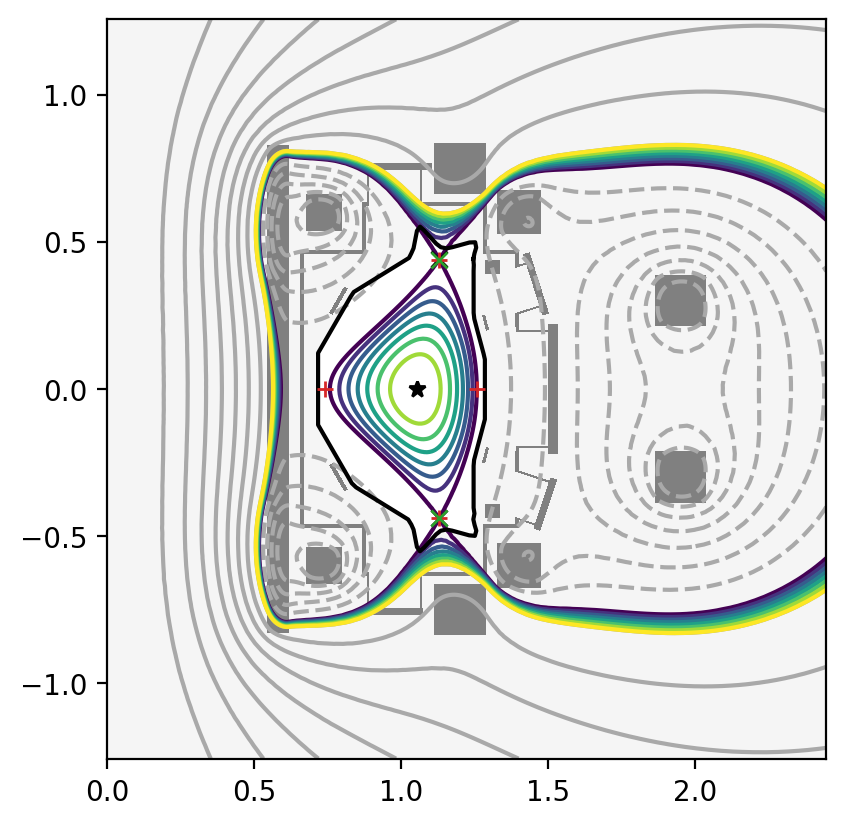

In [12]:
mygs.init_psi(1,0,0.25, 1.7,-0.5)
fig, ax = plt.subplots()
mygs.plot_psi(fig,ax)
mygs.plot_machine(fig,ax)
mygs.plot_constraints(fig,ax)

In [13]:
mygs.init_psi(1,0,0.25, 1.7,-0.5)
mygs.settings.maxits = 100
mygs.update_settings()
mygs.solve()

Starting non-linear GS solver
     1  6.6733E+00  3.0611E+00  1.0802E-02  1.0486E+00  5.3883E-05 -0.0000E+00
     2  6.3979E+00  2.9866E+00  2.1575E-03  1.0457E+00  5.5551E-06 -0.0000E+00
     3  6.2641E+00  2.9435E+00  5.2735E-04  1.0442E+00 -1.7916E-05 -0.0000E+00
     4  6.2041E+00  2.9234E+00  2.1816E-04  1.0434E+00 -2.9368E-05 -0.0000E+00
     5  6.1773E+00  2.9143E+00  1.0459E-04  1.0430E+00 -3.4797E-05 -0.0000E+00
     6  6.1656E+00  2.9102E+00  4.8673E-05  1.0429E+00 -3.7306E-05 -0.0000E+00
     7  6.1605E+00  2.9084E+00  2.1869E-05  1.0428E+00 -3.8415E-05 -0.0000E+00
     8  6.1584E+00  2.9077E+00  9.5767E-06  1.0428E+00 -3.8881E-05 -0.0000E+00
     9  6.1575E+00  2.9073E+00  4.1132E-06  1.0427E+00 -3.9066E-05 -0.0000E+00
    10  6.1571E+00  2.9072E+00  1.7387E-06  1.0427E+00 -3.9135E-05 -0.0000E+00
    11  6.1569E+00  2.9071E+00  7.2487E-07  1.0427E+00 -3.9156E-05 -0.0000E+00
 Timing:  0.18340800004079938     
   Source:     6.2153000850230455E-002
   Solve:      7.9123999457

0

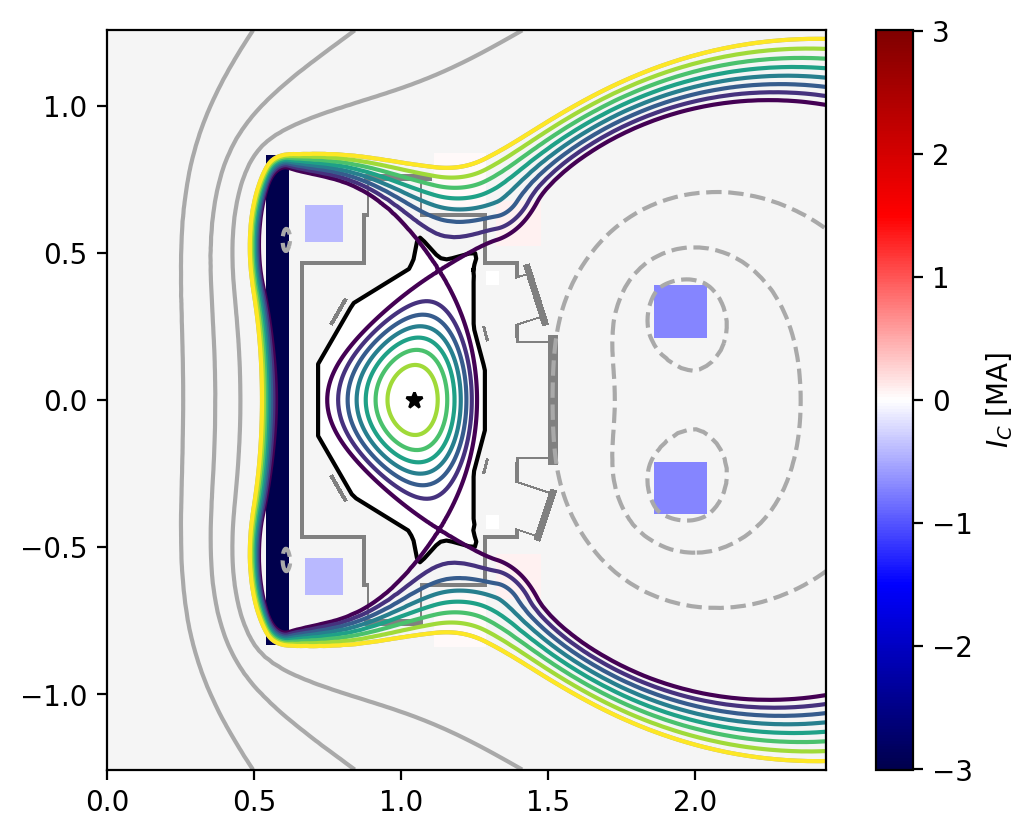

In [14]:
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_symmap=True,coil_scale=1.E-6,coil_clabel=r'$I_C$ [MA]')
mygs.plot_psi(fig,ax,xpoint_color=None,vacuum_nlevels=4)


### Extract flux from plasma current only

   1  4.4463E+04


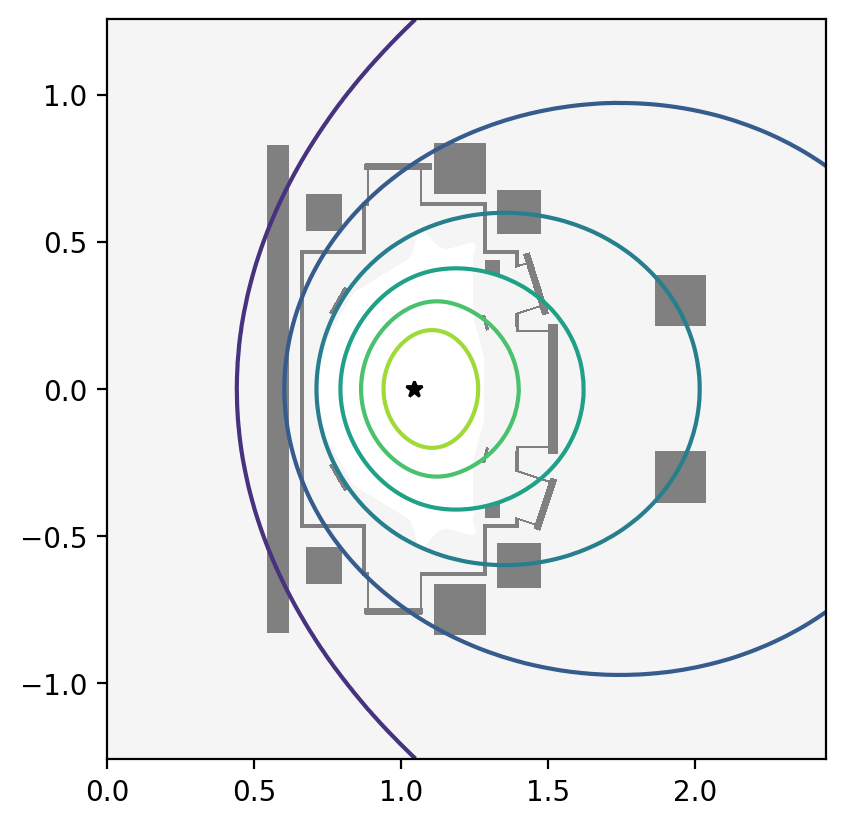

In [15]:
# Get full flux
psi_full = mygs.get_psi(False)
# Compute flux from coils only
mygs.set_psi(0.0*psi_full)
psi_vac, err_flag = mygs.vac_solve()
#psi_vac = mygs.get_psi(False)
# Subtract to yield flux from plasma current
psi_plasma = psi_full-psi_vac
# Save coil currents
coil_currents, _ = mygs.get_coil_currents()
# Plot isolated plasma flux
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,limiter_color=None)
mygs.plot_psi(fig,ax,psi_plasma,normalized=False,xpoint_color=None)

### Perform time-dependent simulation with plasma-current quench source


In [16]:
targets = np.zeros(mygs.ncoils+1)
# Set linear CQ time
CQ_time = 0.65E-3
# Setup simulation
psi_last = np.zeros((mygs.np))
t = 0.0
dt = 0.65E-4
results = [psi_last]
sim_time = [0.0]
mygs.settings.pm=False
mygs.update_settings()
mygs.set_coil_currents(0.0*targets[:-1])
for i in range(120):
    t += dt
    # Set source from last time step w/ or w/o CQ source
    if t <= CQ_time:
        mygs.set_psi_dt(psi_plasma*dt/CQ_time+psi_last,dt)
    else:
        mygs.set_psi_dt(psi_last,dt)
    # Compute next time step
    mygs.set_psi(0.0*psi_last) # Necessary temporarily to initialize zero flux for vacuum solves
    #_ = mygs.solve(vacuum=True)
    psi_last, err_flag = mygs.vac_solve()
    # Save timestep for plotting
    #psi_last = mygs.get_psi(False)
    results.append(psi_last)
    sim_time.append(t)

### Plot results

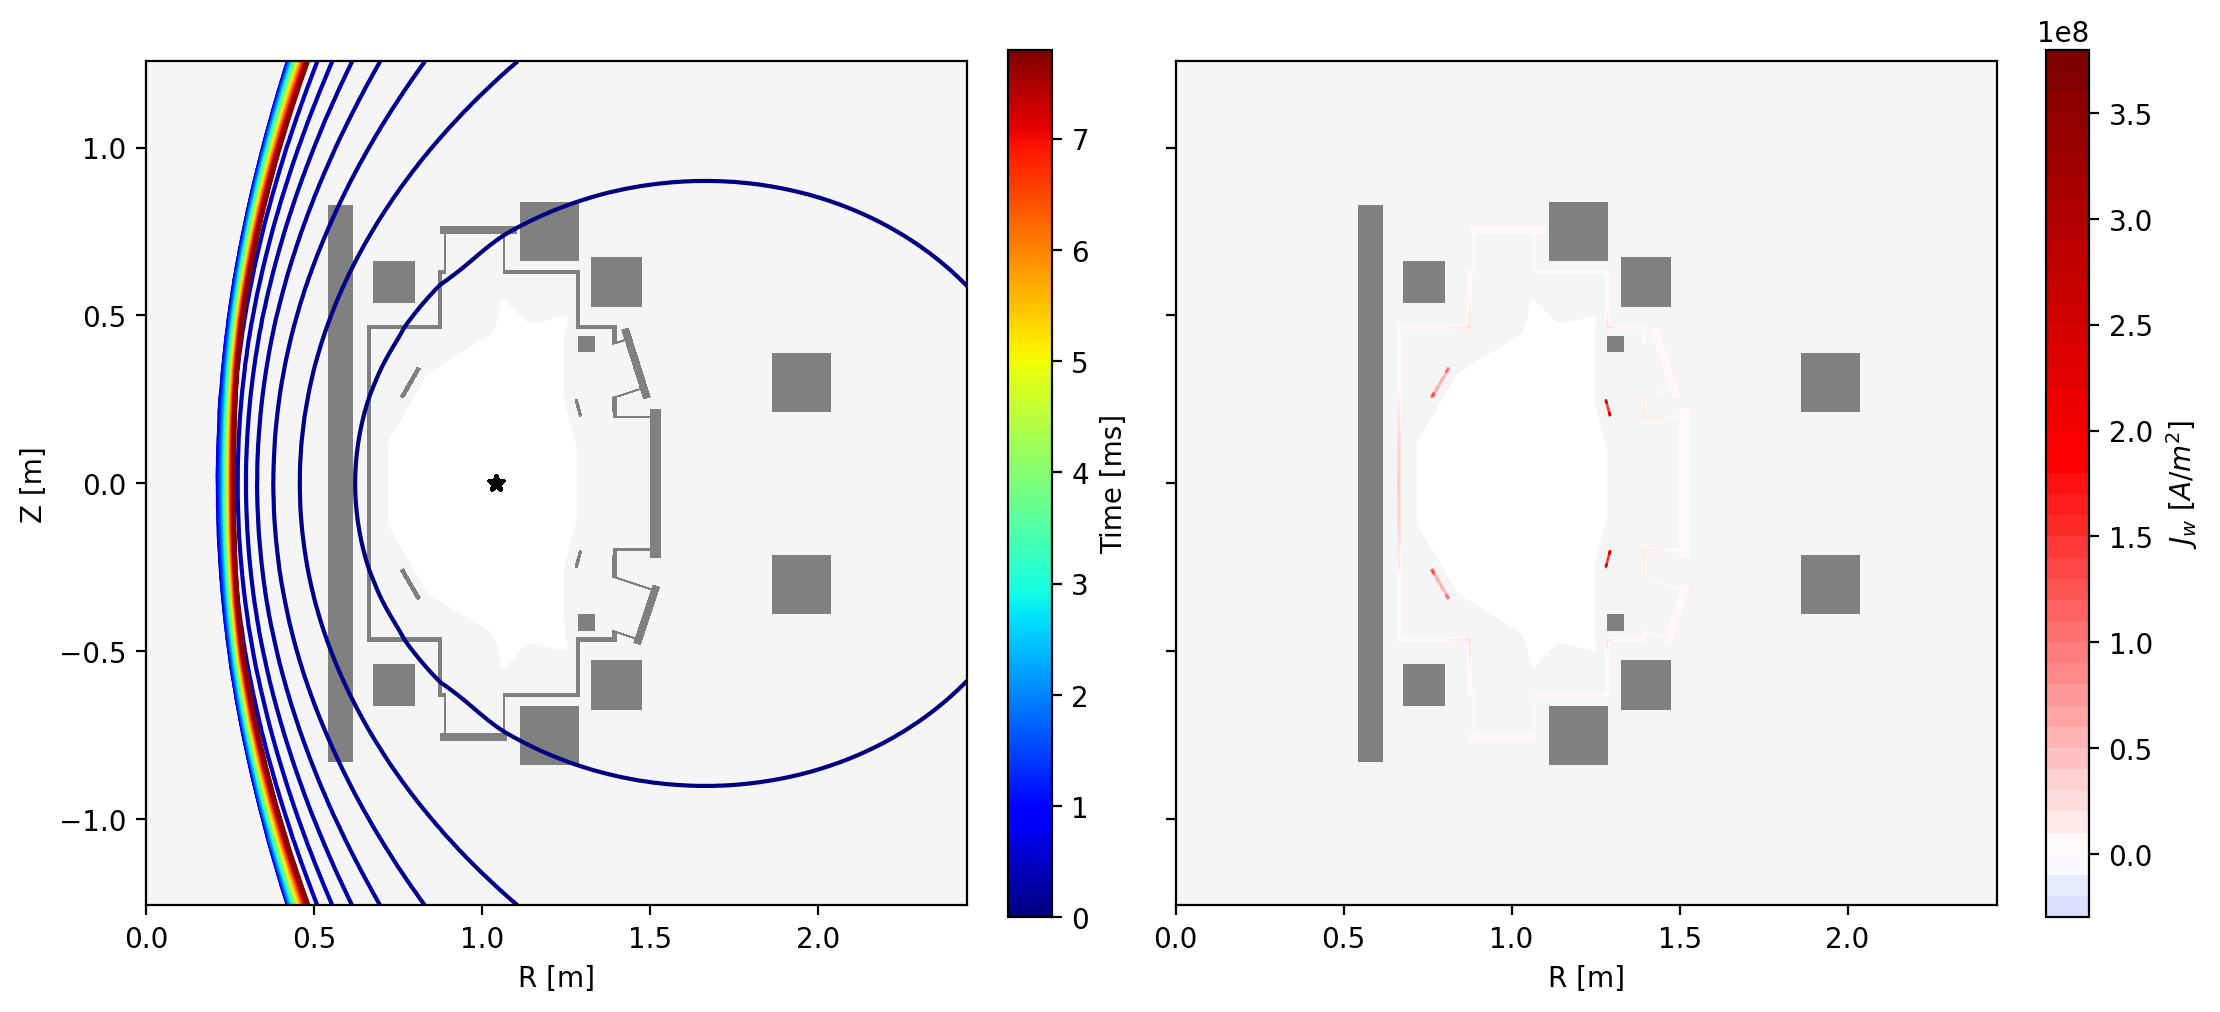

In [17]:
fig, ax = plt.subplots(1,2,sharey=True,figsize=(11,5),constrained_layout=True)
# Plot flux evolution in time
mygs.plot_machine(fig,ax[0],coil_colormap=None,limiter_color=None)
colors = plt.cm.jet(np.linspace(0, 1, len(results)))
for i, result in enumerate(results[1:]):
    mygs.plot_psi(fig,ax[0],psi=result,normalized=False,plasma_levels=[1.E-2],plasma_color=[colors[i]],vacuum_levels=None,xpoint_color=None)
norm = mpl.colors.Normalize(vmin=0.0, vmax=sim_time[-1]*1.E3)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=plt.cm.jet),ax=ax[0],label='Time [ms]')
ax[0].set_ylabel('Z [m]')
ax[0].set_xlabel('R [m]')
# Plot snapshot at t=10 ms
mygs.plot_machine(fig,ax[1],coil_colormap=None,limiter_color=None)
mygs.plot_eddy(fig,ax[1],psi=results[9],colormap='seismic',symmap=True)
_ = ax[-1].set_xlabel('R [m]')

## Compute forces on VV

In [18]:
def get_forces_reg(sample_time, reg_name):
    # Get conductor currents at cell centers
    mask, cond_currents = mygs.get_conductor_currents(results[sample_time],cell_centered=True)
    # Find points inside conducting regions
    mask_vv = np.zeros((mygs.lc.shape[0],), dtype=np.int32)
    mask_vv = (mygs.reg == cond_dict[reg_name]['reg_id'])
    pt_mask = np.zeros((mygs.r.shape[0],), dtype=np.int32)
    pt_mask[mygs.lc[mask_vv,:]] = 1
    # Set psi and evaluate B-field in conducting regions
    mygs.set_psi(psi_vac+results[sample_time])
    field_eval = mygs.get_field_eval('B')
    B_cond = np.zeros((mygs.r.shape[0],3))
    for i in range(mygs.r.shape[0]):
        if pt_mask[i] == 0:
            continue
        B_cond[i,:] = field_eval.eval(mygs.r[i,:2])
    Bv_cond = (B_cond[mygs.lc[:,0],:] + B_cond[mygs.lc[:,1],:] + B_cond[mygs.lc[:,2],:])/3.0
    # Get cell centered positions
    rcc = (mygs.r[mygs.lc[:,0],:] + mygs.r[mygs.lc[:,1],:] + mygs.r[mygs.lc[:,2],:])/3.0
    # Return data
    return cond_currents, Bv_cond, mask_vv, rcc

### Plot snapshot at end of CQ

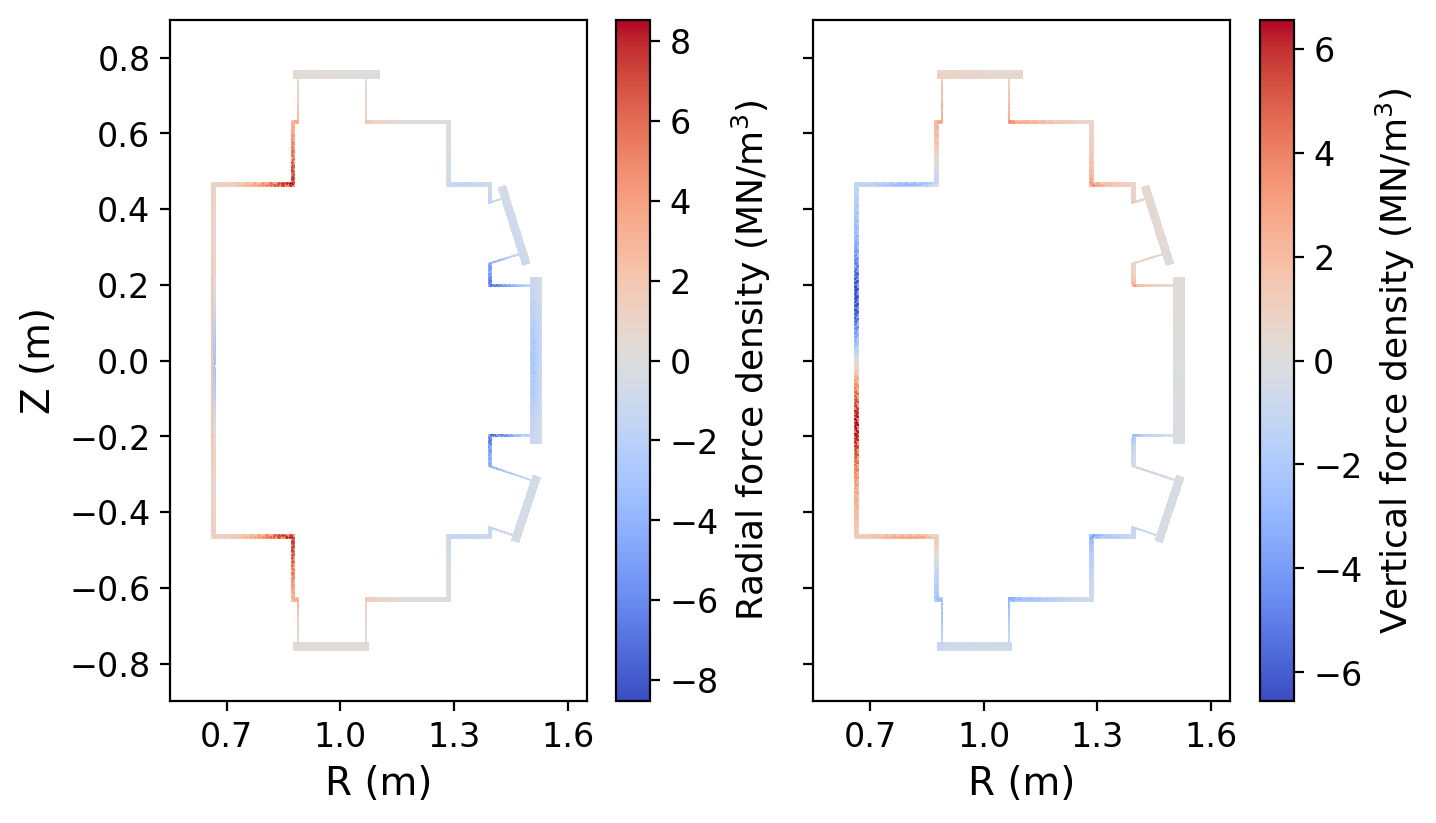

In [19]:
mesh_currents, Bv_cond, mask, rcc = get_forces_reg(10, 'VV')
plt.rcParams['xtick.labelsize'] = 'large'
plt.rcParams['ytick.labelsize'] = 'large'
# Plot results
fig, ax = plt.subplots(1,2,figsize=(7,4),sharey=True,constrained_layout=True)
# Radial force
Fr = mesh_currents[mask]*Bv_cond[mask,2]
vmax = abs(Fr/1E6).max()
clf = ax[0].tripcolor(mygs.r[:,0],mygs.r[:,1],mygs.lc[mask],Fr/1E6,cmap='coolwarm', vmin=-vmax, vmax=vmax)
cb = fig.colorbar(clf,ax=ax[0],label=r'Radial Force per unit volume [$MN/m^3$]')
cb.set_label(label=r'Radial force density ($\mathrm{MN}/\mathrm{m}^3$)', fontsize = 13)
ax[0].set_ylabel('Z (m)', fontsize = 14)
ax[0].set_xlabel('R (m)', fontsize = 14)
# Vertical force
Fz = -mesh_currents[mask]*Bv_cond[mask,0]
vmax = abs(Fz/1E6).max()
clf = ax[1].tripcolor(mygs.r[:,0],mygs.r[:,1],mygs.lc[mask],Fz/1E6,cmap='coolwarm', vmin=-vmax, vmax=vmax)
cb = fig.colorbar(clf,ax=ax[1],label=r'Vertical Force per unit volume [$MN/m^3$]')
cb.set_label(label=r'Vertical force density ($\mathrm{MN}/\mathrm{m}^3$)', fontsize = 13)
_ = ax[1].set_xlabel('R (m)', fontsize = 14)
ax[0].set_ylim(-0.9,0.9)
# Quiver
for ax_tmp in ax:
    ax_tmp.set_xlim(0.55,1.65)
    ax_tmp.set_aspect('equal','box')
    ax_tmp.set_xticks([0.7,1.0, 1.3, 1.6])

In [20]:
dV = np.zeros((mygs.nc,))
for i in range(mygs.lc.shape[0]):
    v1 = mygs.r[mygs.lc[i,1],:]-mygs.r[mygs.lc[i,0],:]
    v2 = mygs.r[mygs.lc[i,2],:]-mygs.r[mygs.lc[i,0],:]
    rcc = (mygs.r[mygs.lc[i,2],:]+mygs.r[mygs.lc[i,1],:]+mygs.r[mygs.lc[i,0],:])/3.0
    dV[i] = 2.0*np.pi*rcc[0]*np.linalg.norm(np.cross(v1,v2))/2.0

Fr_net_in = [0.0 for _ in results]
Fz_net_in = [0.0 for _ in results]

for t in range(len(results)):
    mesh_currents, Bv_cond, mask, rcc = get_forces_reg(t, 'IN_UPPER_PLATE')
    Fr = mesh_currents[mask]*Bv_cond[mask,2]
    Fr_net_in[t] = (Fr*dV[mask]).sum()

    Fz = -mesh_currents[mask]*Bv_cond[mask,0]
    Fz_net_in[t] = (Fz*dV[mask]).sum()
    

Fr_net_out = [0.0 for _ in results]
Fz_net_out = [0.0 for _ in results]

for t in range(len(results)):
    mesh_currents, Bv_cond, mask, rcc = get_forces_reg(t, 'OUT_UPPER_PLATE')
    Fr = mesh_currents[mask]*Bv_cond[mask,2]
    Fr_net_out[t] = (Fr*dV[mask]).sum()

    Fz = -mesh_currents[mask]*Bv_cond[mask,0]
    Fz_net_out[t] = (Fz*dV[mask]).sum()



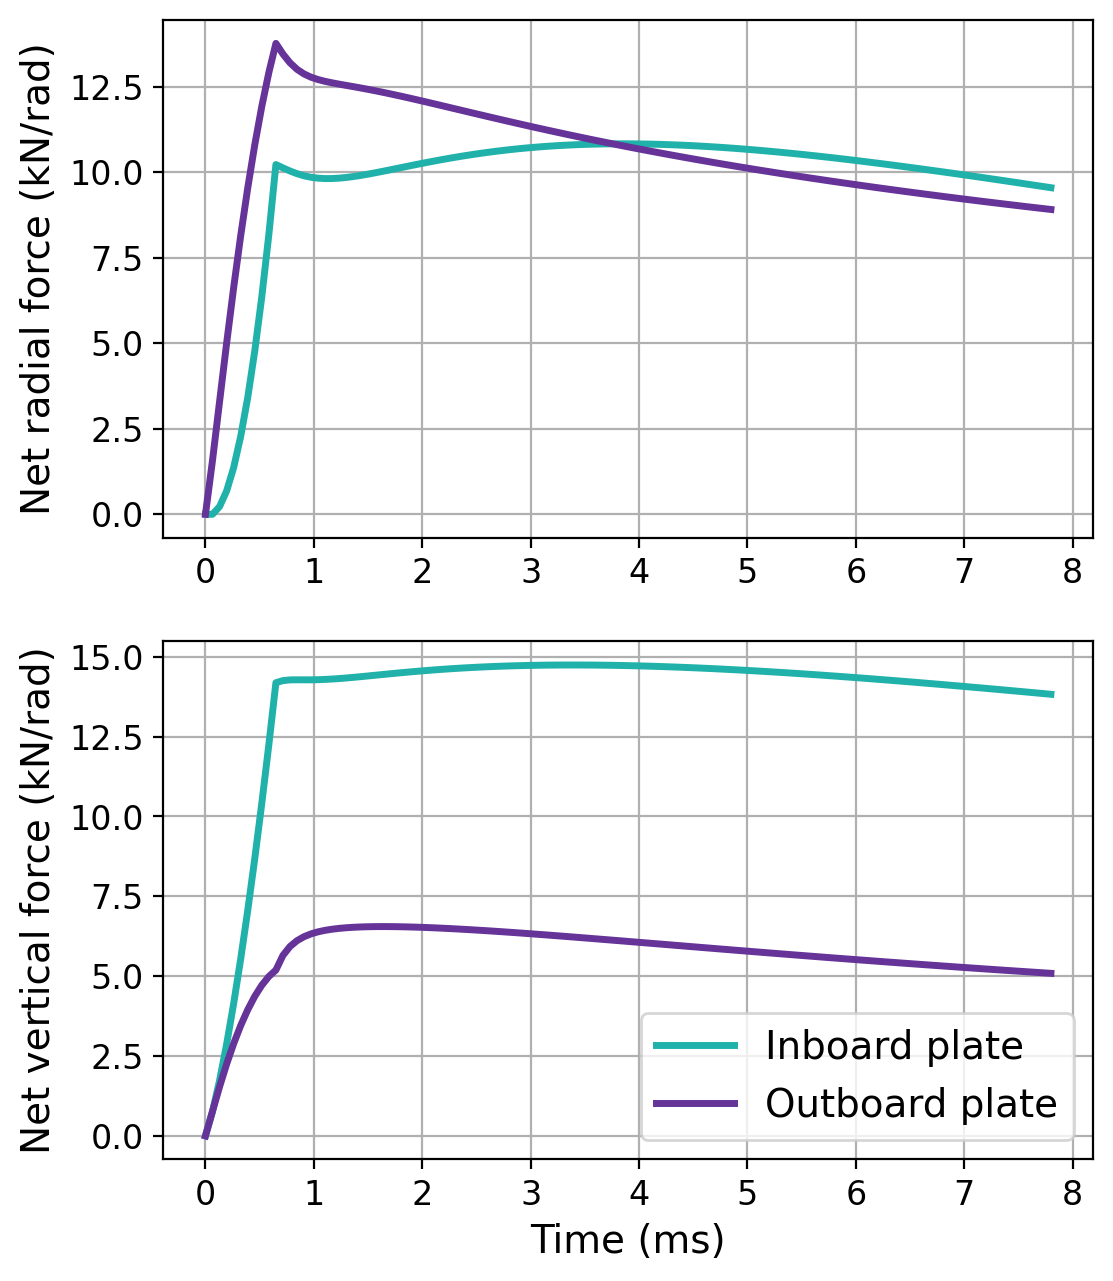

In [21]:
plt.rcParams['xtick.labelsize'] = 'large'
plt.rcParams['ytick.labelsize'] = 'large'
fig, ax = plt.subplots(2,1,figsize = (6,7.4))
ax[0].plot(np.asarray(sim_time)*1.E3,np.abs(np.asarray(Fr_net_in)/1.E3/(2.0*np.pi)), linewidth = 2.5, label = 'Inboard plate', color = 'lightseagreen')
ax[0].plot(np.asarray(sim_time)*1.E3,np.abs(np.asarray(Fr_net_out)/1.E3/(2.0*np.pi)),linewidth = 2.5, label = 'Outboard plate', color = 'rebeccapurple')
#ax[0].legend(fontsize = 14)
ax[1].plot(np.asarray(sim_time)*1.E3,np.abs(np.asarray(Fz_net_in)/1.E3/(2.0*np.pi)),linewidth = 2.5, label = 'Inboard plate',color = 'lightseagreen')
ax[1].plot(np.asarray(sim_time)*1.E3,np.abs(np.asarray(Fz_net_out)/1.E3/(2.0*np.pi)),linewidth = 2.5, label = 'Outboard plate',color = 'rebeccapurple')
ax[1].legend(fontsize = 14)
ax[0].set_ylabel('Net radial force (kN/rad)', fontsize = 14)
ax[1].set_ylabel('Net vertical force (kN/rad)', fontsize = 14)
ax[1].set_xlabel('Time (ms)', fontsize = 14)
for a in ax:
    a.grid()